In [ ]:
#default_exp batch

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
#from fastai.vision.all import *
import tensorflow.compat.v1 as tf
#import pydicom
from pydicom import dcmread
from tempfile import mkstemp
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#exporti
import os
import pandas as pd
from misas.core import *
from misas.mri import *
import altair as alt
from tqdm.notebook import tqdm
from tempfile import mkdtemp
from functools import partial

import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import math
from shutil import rmtree

## Aim: Getting a first impression on the models performance on the given data before going into detailed evaluation

In this case study we demonstrate how `misas` can give you an overview of the performance of the model by creating plots that show the average dice score of the whole batch of images over different parameters:
 - **Model**: `ukbb_cardiac` [network](https://github.com/baiwenjia/ukbb_cardiac) by [Bai et al. 2018 [1]](https://doi.org/10.1186/s12968-018-0471-x), trained on [UK Biobank](https://www.ukbiobank.ac.uk/) cardiac MRI images
 - **Data**: Kaggle [Data Science Bowl Cardiac Challenge Data](https://www.kaggle.com/c/second-annual-data-science-bowl) MRI images

# Prepare Model for Misas

The used model was trained on UK Biobank cardiac imaging data to segment short-axis images of the heart into left ventricle (LV), right ventricle (RV) and myocardium (MY). For details about the model please read [the paper (Bai et al. 2018)](https://doi.org/10.1186/s12968-018-0471-x) and cite it if you use it. For implementation, training and usage see the [GitHub repository](https://github.com/baiwenjia/ukbb_cardiac). We downloaded the pre-trained model for short-axis images from https://www.doc.ic.ac.uk/~wbai/data/ukbb_cardiac/trained_model/ (local copy in `example/kaggle/FCN_sa`). In order to use it with `misas` we need to wrap it in a class that implements the desired interface (`prepareSize` and `predict` taking `Image` as input, see the main docu for more details).

`ukbb_cardiac` is written in `tensorflow` v1. With `tensorflow` v2 make sure to import the compat module.

The model requires images to be a multiple of 16 in each dimension. We pad images accordingly in `prepareSize`. Additionally, code in `image_to_input` takes care of the specifics of transforming a three-channel image into a single-item batch of single-channel images. In `predict` the output is converted to `ImageSegment` class.

In [ ]:
#class ukbb_model:
#    def __init__(self, model_path):
#        tf.disable_eager_execution()
#        self.sess = tf.Session()
#        self.sess.run(tf.global_variables_initializer())
#        saver = tf.train.import_meta_graph(f'{model_path}.meta')
#        saver.restore(self.sess, model_path)
#        
#    def prepareSize(self, image):
#        _, X, Y = image.shape
#        image.crop_pad((int(math.ceil(X / 16.0)) * 16, int(math.ceil(Y / 16.0)) * 16), padding_mode="zeros")
#        return image
#    
#    def image_to_input(self, image):
#        img = image.clone()
#        self.prepareSize(img)
#        img_data = img.data[0]
#        img_data = np.expand_dims(img_data, 0)
#        img_data = np.expand_dims(img_data, -1)
#        return img_data
#    
#    def predict(self, image):
#        image_data = self.image_to_input(image)
#        preds, classes = self.sess.run(['prob:0', 'pred:0'],
#                   feed_dict={'image:0': image_data, 'training:0': False})
#        preds = np.squeeze(preds, 0)
#        classes = ImageSegment(ByteTensor(classes))
#        return classes, preds

In [ ]:
class ukbb_model:
    def __init__(self, model_path):
        tf.disable_eager_execution()
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(f'{model_path}.meta')
        saver.restore(self.sess, model_path)
        
    def prepareSize(self, image):
        #_, X, Y = image.shape
        X, Y = image.shape
        #print(image.shape)
        #print(image.shape)
        image=image.crop_pad((int(math.ceil(X / 16.0)) * 16, int(math.ceil(Y / 16.0)) * 16))
        return image
    
    def image_to_input(self, image):
        img = image
        img = np.array(img)[:,:,0]
        img = img/255
        img = np.expand_dims(img, 0)
        img = np.expand_dims(img, -1)
        #self.prepareSize(img)
        #print(img.shape)
        ##img_data = np.expand_dims(img, 0)
        #img_data = np.array(img)[0]
        #print(img.shape)
        #img_data = np.expand_dims(img_data, 0)
        #print(img.shape)
        #img_data = np.expand_dims(img_data, -1)
        #print(img.shape)
        return img
    
    def predict(self, image):
        image = self.image_to_input(image)
        preds, classes = self.sess.run(['prob:0', 'pred:0'],
                   feed_dict={'image:0': image, 'training:0': False})
        preds = np.squeeze(preds, 0)
        preds = np.argmax(preds, axis = 2)
        preds = preds.astype(np.uint8)
        preds = Image.fromarray(preds)
        #preds = Image.fromarray(np.array(preds))
        #classes = ImageSegment(ByteTensor(classes))
        
        return preds #classes,
        

In [ ]:
model = ukbb_model('example/kaggle/FCN_sa')
import warnings
warnings.filterwarnings('ignore')

INFO:tensorflow:Restoring parameters from example/kaggle/FCN_sa


# Prepare Images

In [ ]:
#def windowed(tensor, width, center):
#    '''Scale pixel intensity by window width and window center'''
#    px = tensor.clone()
#    px_min = center - width//2
#    px_max = center + width//2
#    px[px<px_min] = px_min
#    px[px>px_max] = px_max
#    return (px-px_min) / (px_max-px_min)

In [ ]:
##exporti

def dicom_to_Image(fname):
    ds = dcmread(fname)
    img = (ds.pixel_array.astype(np.int16))
    img = (img/img.max()*255).astype(np.uint8)
    img = Image.fromarray(np.array(img))
    return img.convert("RGB")
    
#def dicom_to_Image(file):
#    '''Reading the Dicom file and bringing the image into correct format and orientation for downstream evaluations'''
#    dcm = pydicom.dcmread(file)
#    img = Tensor(dcm.pixel_array.astype(np.int16))
#    img = windowed(img, dcm.WindowWidth, dcm.WindowCenter)
#    img = Image(torch.stack([img, img, img]))    # to convert Tensor into Image object, 3 dimensions are needed
#    img = img.flip_lr()
#    img = img.rotate(90)
#    return img

For these demonstration purposes, images are selected randomly from all images that have the attributes "Slice Location and "Trigger Time" and that are not automatically generated images that contain plain text or multiple images:

In [ ]:
images = ["example/kaggle/sample_images/IM-13717-0026.dcm",
        "example/kaggle/sample_images/IM-7453-0024.dcm",
        "example/kaggle/sample_images/IM-4718-0021.dcm",
        "example/kaggle/sample_images/IM-5022-0015.dcm",
        #"example/kaggle/sample_images/IM-14141-0011.dcm",
        #"example/kaggle/sample_images/IM-13811-0003.dcm",
        #"example/kaggle/sample_images/IM-5382-0008.dcm"
        ]
#images = []
#for file in files:
#    ds = dcmread(file)
#    images.append(file)
#len(images)

In [ ]:
#print(images)
print(dicom_to_Image(images[0]))
np.array(dicom_to_Image(images[0])).shape
dicom_1=dicom_to_Image(images[0])

<PIL.Image.Image image mode=RGB size=192x256 at 0x7F54285C13A0>


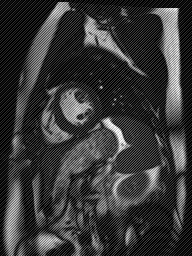

In [ ]:
spikeTransform(dicom_1, 1)

# Evaluation

If true_masks is "None", the model will predict a mask for every image, save it as png in a newly created directory and use this mask as truth for the evaluation and afterwards delete the directory and the contained predicted thruths. Thus, it is important to hand in the images in an orientation in which the model makes good predictions, in this case this is handled, by the "prepareImage" function, which reads the dicom file, converts it to a fastai Image object, and rotates and flips the image into correct position

In [ ]:
#export
def batch_results(images, model, eval_functions, true_masks=None, components=['bg','LV','MY','RV']):
    ''' Evaluation of the models performance across multiple images and transformations
    
    -images (list): paths for dicom files with which the model should be evaluated
    -model: model to be evaluated
    -eval_functions (dictionary): keys: name of transformation, values: eval functions from misas.core
    -true_masks (list, optional): paths of png files with true masks for dicoms in 'images' in the same order as 'images'
    -components (list, optional): classes that will be evaluated by the eval functions
    
    Returns: list of Pandas dataFrames, that contains one dataFrame for each image with the columns: 'parameter', 'bg', 'LV', 'MY', 'RV', 'File'
    '''
    results = []
    for number, x in enumerate(tqdm(eval_functions, leave=False)):
        trfm_result = []
        for index, i in enumerate(images):
            img = lambda: dicom_to_Image(i)
            #tmp = tempfile.mkdtemp()
            tmp = mkdtemp()
            if true_masks == None:
                truth_path = os.path.join(tmp, "current_truth.png")
                truth = model.predict(img()) #[0]
                truth.save(truth_path)
                true_mask = lambda: Image.open(truth_path)
            elif true_masks != None:
                true_mask = lambda: Image.open(true_masks[index])
            transform_function = list(eval_functions.values())[number]
            df = transform_function(img(), true_mask(), model, components=components)
            df["File"] = i
            df["Transformation"] = list(eval_functions.keys())[number]
            trfm_result.append(df)
            #shutil.rmtree(tmp)
            rmtree(tmp)
        trfm_result = pd.concat(trfm_result)
        results.append(trfm_result)
    return results

In this example we are passing a list of true masks to the function that will be used for evaluation. Since this is only for demonstration purposes, we will manually generate the list of true masks by predicting the truth for every image and saving it to a temporary directory and storing the path names in a list, from where `batch_results` can access it.

In [ ]:
truths = []
for i in images:
    img = dicom_to_Image(i)
    truth = model.predict(img)#[0]
    tmpfile = mkstemp()
    truth.save(tmpfile[1] + ".png")
    truths.append(tmpfile[1] + ".png")

The functions will be passed to `batch_results()` in a dictionary. The keys are the names of the respective transformations, which will also be used for the title of the final plots. The values are the eval_functions from misas.core. In this case we called them with `partial()` to edit the parameter nams and start/end/step parameters:

In [ ]:
results_with_truths = batch_results(images, model, {
                                    "Rotation": partial(eval_rotation_series, param_name="Degrees"),
                                    "Brightness": partial(eval_bright_series, param_name="Relative Brightness", start=0.025, end=.975, step=0.025),
                                    "Cropping": partial(eval_crop_series, param_name="Image size in Pixels"),
                                    "Contrast": partial(eval_contrast_series, param_name="Relative Contrast", start=0.1, end=4.5, step=0.1),
                                    "Resizing": partial(eval_resize_series, param_name="Pixels", start=20, end=700, step=25),
                                    "Spike Artefact Intensity": partial(eval_spike_series, param_name="Intensity", step=.01, start=0, end=.5),
                                    "Spike Artefact Position": partial(eval_spike_pos_series, param_name="X Position of Spike", step=0.025, intensityFactor=0.2),
                                    "Zoom": partial(eval_zoom_series, param_name="Scale")
                                    }, components=['bg','LV','MY','RV'], true_masks=truths)
dihedral_results_with_truths = batch_results(images, model, {"Orientation": partial(eval_dihedral_series, param_name="Orientation")}, components=['bg','LV','MY','RV'], true_masks=truths)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
#results_with_truths = batch_results(images, model, {
#                                    "Rotation": partial(eval_rotation_series, param_name="Degrees"),
#                                    "Brightness": partial(eval_bright_series, param_name="Relative Brightness", start=0.025, end=.975, step=0.025),
#                                    "Cropping": partial(eval_crop_series, param_name="Image size in Pixels"),
#                                    "Contrast": partial(eval_contrast_series, param_name="Relative Contrast", start=0.1, end=4.5, step=0.1),
#                                    "Resizing": partial(eval_resize_series, param_name="Pixels", start=20, end=700, step=25),
#                                    "Spike Artefact Intensity": partial(eval_spike_series, param_name="Intensity", step=.01, start=0, end=.5),
#                                    "Spike Artefact Position": partial(eval_spike_pos_series, param_name="X Position of Spike", step=0.025, intensityFactor=0.2),
#                                    "Zoom": partial(eval_zoom_series, param_name="Scale")
#                                    }, components=['bg','LV','MY','RV'], true_masks=truths)
#dihedral_results_with_truths = batch_results(demo_files, model, {"Orientation": partial(eval_dihedral_series, param_name="Orientation")}, components=['bg','LV','MY','RV'], true_masks=truths)

For the dihedral transformation we are storing the evaluation in a separate variable, so we can create a plot that looks different from the others:

In the following we demonstrate that the function can also evaluate the models performance without passing a list of true masks to the function. In this case the model will make a prediction for every image, save it as png and use it as a true mask for evaluation. In this case it is important that the evaluated images are passed to the function in an orientation in which the model can make a good prediction, since this prediction is used as the true mask for all the following transformations. In this case the "right" orientation was evaluated by applying dihedral/rotation transformations to one single example image and evaluating the predictions with misas. Bringing all the images for batch evaluation into this desired orientation is in this case handled by the `dicom_to_Image` function, but it has to be manually adapted if a different set of data or a different model is used.

In [ ]:
results_without_truths = batch_results(images, model, {
                                    "Rotation": partial(eval_rotation_series, param_name="Degrees"),
                                    #"Brightness": partial(eval_bright_series, param_name="Relative Brightness", start=0.025, end=.975, step=0.025),
                                    #"Cropping": partial(eval_crop_series, param_name="Image size in Pixels"),
                                    #"Contrast": partial(eval_contrast_series, param_name="Relative Contrast", start=0.1, end=4.5, step=0.1),
                                    #"Resizing": partial(eval_resize_series, param_name="Pixels", start=20, end=700, step=25),
                                    #"Spike Artefact Intensity": partial(eval_spike_series, param_name="Intensity", step=.01, start=0, end=.5),
                                    #"Spike Artefact Position": partial(eval_spike_pos_series, param_name="X Position of Spike", step=0.025, intensityFactor=0.2),
                                    #"Zoom": partial(eval_zoom_series, param_name="Scale")
                                    }, components=['bg','LV','MY','RV'])
dihedral_results_without_truths = batch_results(images, model, {"Orientation": partial(eval_dihedral_series, param_name="Orientation")}, components=['bg','LV','MY','RV'])

In this demonstration `results_with_truths` and `results_without_truths` is the same because in both cases, the truths are predicted by the model, hence we will continue with the demonstration only with one of the two lists.

# Plotting the results

In [ ]:
#export
def plot_avg_and_dots(df, draw_line=True, dots="single_values", value_name='Dice Score'):
    '''
    Plots the average dice score and shows the single data points
    
    Positional arguments:
    -df (pd.DataFrame object): columns: 'parameter', 'bg', 'LV', 'MY', 'RV', 'File'
    -draw_line (Boolean): determines if the line between the average of the datapoints is drawn
    -dots (string): "single_values" or "average"_ determines wether the dots show every single datapoint or one point for the average for each parameter
    -value_name (str): Name for the Y axis. Depending on which evaluation Score you used in the evaluation function, you can change the Label for the Y axis here.
    
    Returns: altair.FacetChart object
    '''
    melt_results = df.melt(id_vars=df.columns[0], value_vars=df.columns[2:5], value_name=value_name)
    if dots == "single_values":
        dot_plot = alt.Chart(melt_results
                ).mark_point(
                ).encode(x=melt_results.columns[0], y=alt.Y(f"{value_name}", scale=alt.Scale(domain=(0, 1.1))), color=alt.Color("variable")
                ).properties(width=400, height=200
                ).interactive()
    elif dots == "average":
        dot_plot = alt.Chart(melt_results
                ).mark_point(
                ).encode(x=melt_results.columns[0], y=alt.Y(f"average({value_name})", scale=alt.Scale(domain=(0, 1.1))), color=alt.Color("variable")
                ).properties(width=400, height=200
                ).interactive()
    if draw_line == True:
        avg_line_plot = alt.Chart(melt_results
                    ).mark_line(
                    ).encode(x=melt_results.columns[0], y=f"average({value_name})", color=alt.Color("variable")
                    ).properties(width=400, height=200
                    ).interactive()
        plot = alt.layer(dot_plot, avg_line_plot).facet(column="variable")
    else:
        plot = dot_plot.facet(column="variable")
    return plot

In [ ]:
#export
def plot_avg_and_errorbars(df, value_name='Dice Score'):
    '''
    Plots the average dice score and shows the stdev as errorbars.
    
    Positional arguments:
    -df (pd.DataFrame object): columns: 'parameter', 'bg', 'LV', 'MY', 'RV', 'File'
    -value_name (str): Name for the Y axis. Depending on which evaluation Score you used in the evaluation function, you can change the Label for the Y axis here.
    
    Returns: altair.FacetChart object
    '''
    melt_results = df.melt(id_vars=df.columns[0], value_vars=df.columns[2:5], value_name=value_name)
    avg_line_plot = alt.Chart(melt_results
                ).mark_line(
                ).encode(x=melt_results.columns[0], y=f"average({value_name})", color=alt.Color("variable")
                ).properties(width=400, height=200
                ).interactive()
    error_bars = alt.Chart(melt_results
                ).mark_errorbar(extent='stdev'#, ticks=True
                ).encode(x=melt_results.columns[0], y=value_name, color=alt.Color("variable"))
    plot = alt.layer(avg_line_plot, error_bars).facet(column="variable")
    return plot

In [ ]:
#export
def plot_boxplot(df, value_name='Dice Score'):
    '''
    Plots the average dice score as boxplots
    
    Positional arguments:
    -df (pd.DataFrame object): columns: 'parameter', 'bg', 'LV', 'MY', 'RV', 'File'
    -value_name (str): Name for the Y axis. Depending on which evaluation Score you used in the evaluation function, you can change the Label for the Y axis here.
    
    Returns: altair.FacetChart object
    '''
    melt_results = df.melt(id_vars=df.columns[0], value_vars=df.columns[2:5], value_name=value_name)
    plot = alt.Chart(melt_results
                ).mark_boxplot(extent="min-max", size=5
                ).encode(x=alt.X(melt_results.columns[0]), y=alt.Y(value_name), color=alt.Color("variable")
                ).properties(width=400, height=200
                ).facet(column="variable"
                ).interactive()
    return plot

In [ ]:
#export
def plot_batch(df_results, plot_function=plot_avg_and_dots):
    '''
    Creates and displays the plots with the data as returned by the batch_results functions. 
    
    Positional arguments:
    -df_results (list): dataframes which contains one dataFrame for each transformation in a format as it is returned by `batch_results`
    Keyword arguments:
    -plot_function:
        - plot_avg_and_errorbars: plots the average of the dice score of all images across the parameters and shows the standarddeviation as errorbars
        - plot_avg_and_dots: plots the average of the dice score and additionally shows the single datapoints instead of errorbars
        - plot_boxplot
    
    Returns: List with altair.FacetChart objects
    '''
    plots = []
    for index, i in enumerate(df_results):
        plot = plot_function(i)
        plot = plot.properties(title=df_results[index]["Transformation"].values[0]
                ).configure_legend(labelFontSize=13, title=None
                ).configure_axisX(titleFontSize=13, labelFontSize=13
                ).configure_axisY(titleFontSize=13, labelFontSize=13
                ).configure_header(titleFontSize=25, labelFontSize=13, title=None, labels=False
                ).configure_title(fontSize=20, anchor='middle')
        plots.append(plot)
    for p in plots:
        p.display()
    return plots

In [ ]:
plots = plot_batch(results_with_truths, plot_avg_and_errorbars)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

For the dihedral series it does not make any sense to draw the line between the datapoints, hence the results were stored in a seperate variable to be plotted differently:

In [ ]:
plot_batch(dihedral_results_with_truths, partial(plot_avg_and_dots, draw_line=False, dots="average"))

alt.FacetChart(...)

[alt.FacetChart(...)]

When calling `plot_batch` with the parameter `partial(plot_avg_and_dots, dots="single_values")`, which plots the average plus all the single datapoints, it might look like something went wrong because for some images the dice score seems to be 1 across all parameters. If you look at the images and predictions in detail, like shown below, you can see that for some of the images, the model could not predict any classes, even for the original non-transformed image, which will be used as the truth. Thus, when no prediction can be made for the other transformations the prediction is technically right and results in a dice score of 1. The cause may either be that in the respective images are actually none of the classes present, but the cause can also be, that we are just predicting our truths and it could look different if we used manually created true masks, this has to be kept in mind when interpreting the results.

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

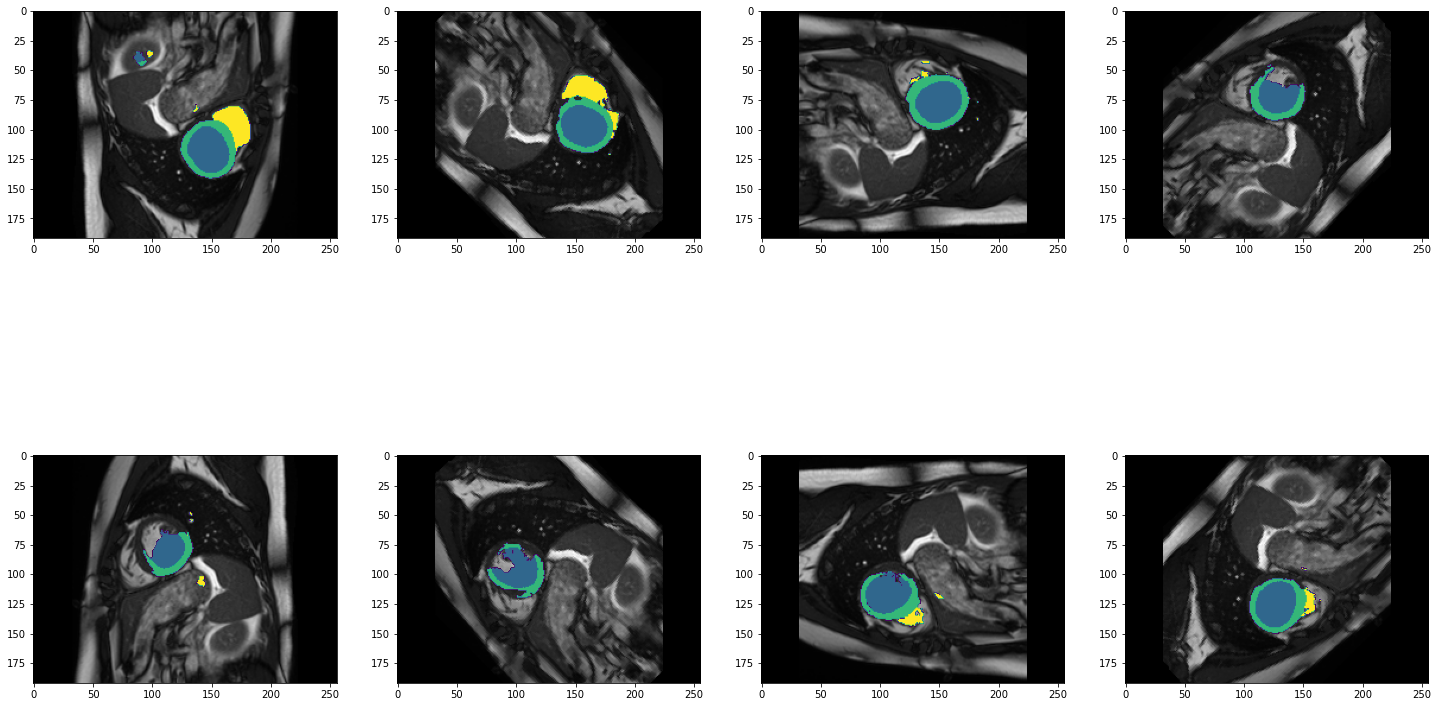

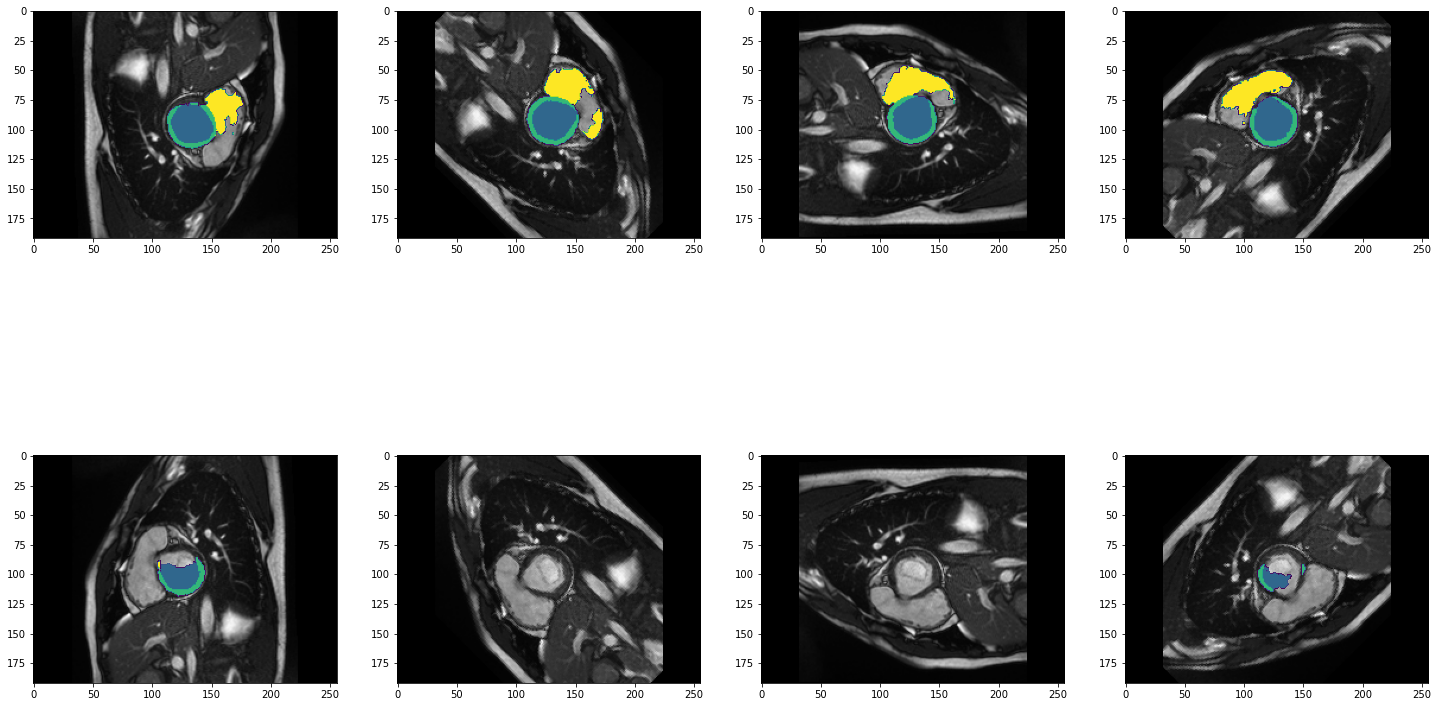

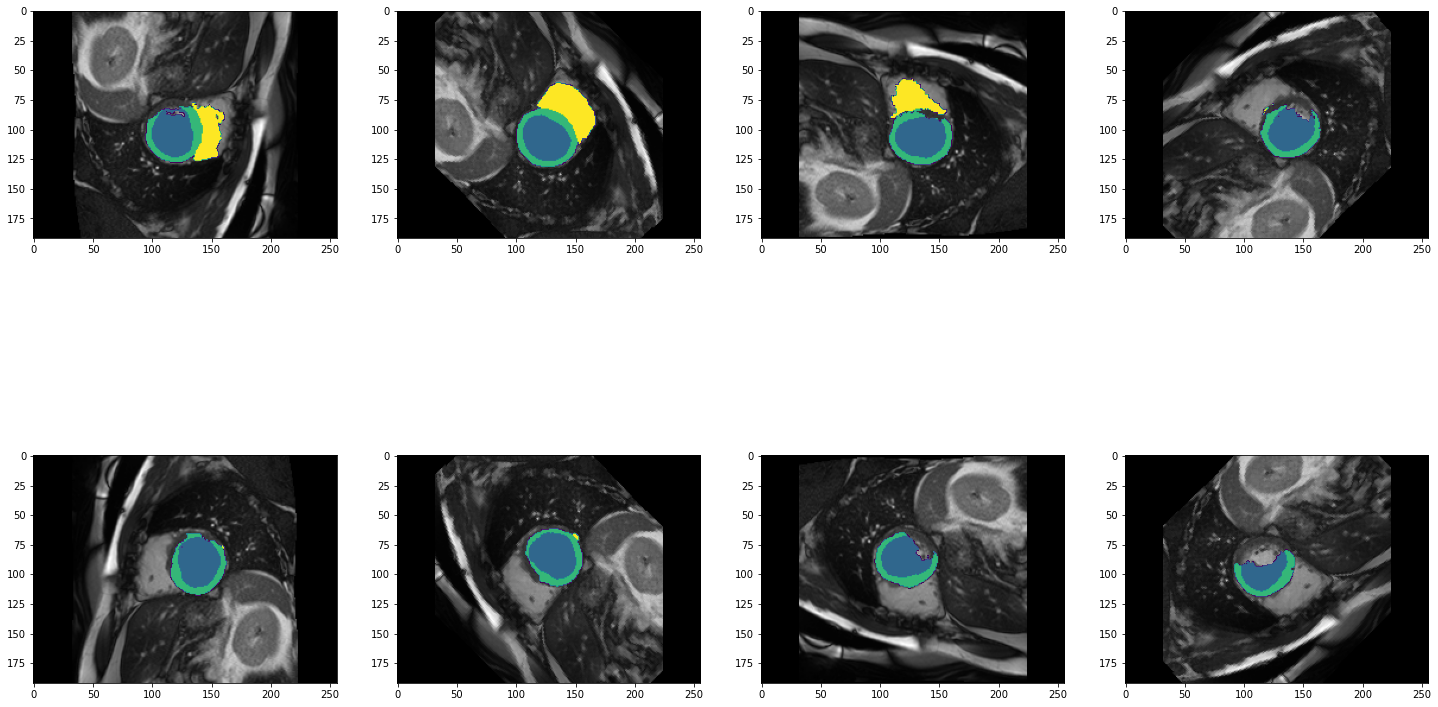

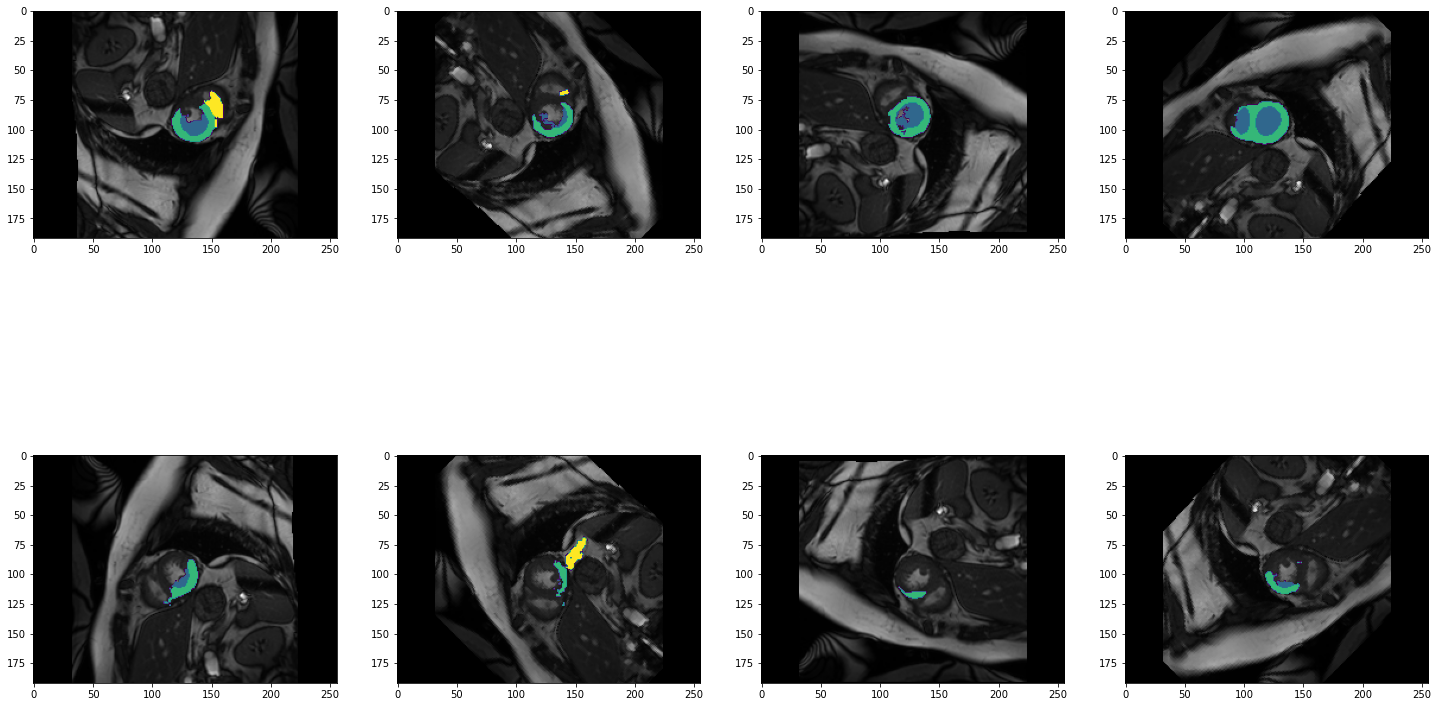

In [ ]:
for i in images:
    img = lambda: dicom_to_Image(i)
    rotation_series = get_rotation_series(img(), model, start=-180, end=180, step=45) #tfm_y=True
    plot_series(rotation_series, nrow=2, figsize=(25,15), vmax=None, param_name='Degree')